# Compare Predictive Performance and Uncertainty Performance for Bootstrapping vs. K-Fold

<hr/>

#### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Constants

In [2]:
DATA_FOLDER = '../../../data/generated_by_notebooks/'
PLOT_FOLDER = './plots/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_names = ['RF', 'XGB', 'SVM', 'Shallow', 'Deep']
algorithm_to_name = dict(zip(algorithms, algorithm_names))

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'MFC', 'RDKit', 'CDDD']
descriptor_to_name = dict(zip(descriptors, descriptor_names))

# Names of the datasets that were run with both KFold and Bootstrapping
dataset_names = [
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'P16581',
    'P18089',
    'P28482'
]

#### Functions

In [4]:
def load_cumulative_results_table(subsampling, name, algorithm, performance):
    """Loads results for a specific dataset and modeling technique setting, for predictive or uncertainty performance."""
    if subsampling == 'kfold':
        path = f'{DATA_FOLDER}cumulative_performances/{performance}/{name}/{name}_{algorithm}.csv'
    elif subsampling == 'bootstrap':
        path = f'{DATA_FOLDER}cumulative_performances_bootstrap/{performance}/{name}/{name}_{algorithm}.csv'
    table = pd.read_csv(path, sep=';').rename(columns={'Unnamed: 0': 'descriptor'})
    table['name'] = [get_dataset_name_correct(name) for _ in range(4)]
    table['algorithm'] = [algorithm_to_name[algorithm] for _ in range(4)]
    # Bring columns in correct order
    table = table[['name', 'algorithm'] + list(table.columns[:-2])]
    return table


def get_dataset_name_correct(name):
    """Formats a dataset name."""
    if name == 'tetrahymena':
        return 'Tetrahymena'
    elif name == 'freesolv':
        return 'FreeSolv'
    elif name == 'esol':
        return 'ESOL'
    else:
        return name

<hr/>

#### Load data

KFold

In [5]:
kf_pred_summary = pd.DataFrame()
kf_unct_summary = pd.DataFrame()

for name in dataset_names:
    for algorithm in algorithms:
        pred = load_cumulative_results_table('kfold', name, algorithm, 'predictive')
        unct = load_cumulative_results_table('kfold', name, algorithm, 'uncertainty')
        kf_pred_summary = pd.concat([kf_pred_summary, pred])
        kf_unct_summary = pd.concat([kf_unct_summary, unct])

Bootstrap

In [6]:
bt_pred_summary = pd.DataFrame()
bt_unct_summary = pd.DataFrame()

for name in dataset_names:
    for algorithm in algorithms:
        pred = load_cumulative_results_table('bootstrap', name, algorithm, 'predictive')
        unct = load_cumulative_results_table('bootstrap', name, algorithm, 'uncertainty')
        bt_pred_summary = pd.concat([bt_pred_summary, pred])
        bt_unct_summary = pd.concat([bt_unct_summary, unct])

#### Make barplots and collect differences

Predictive performance

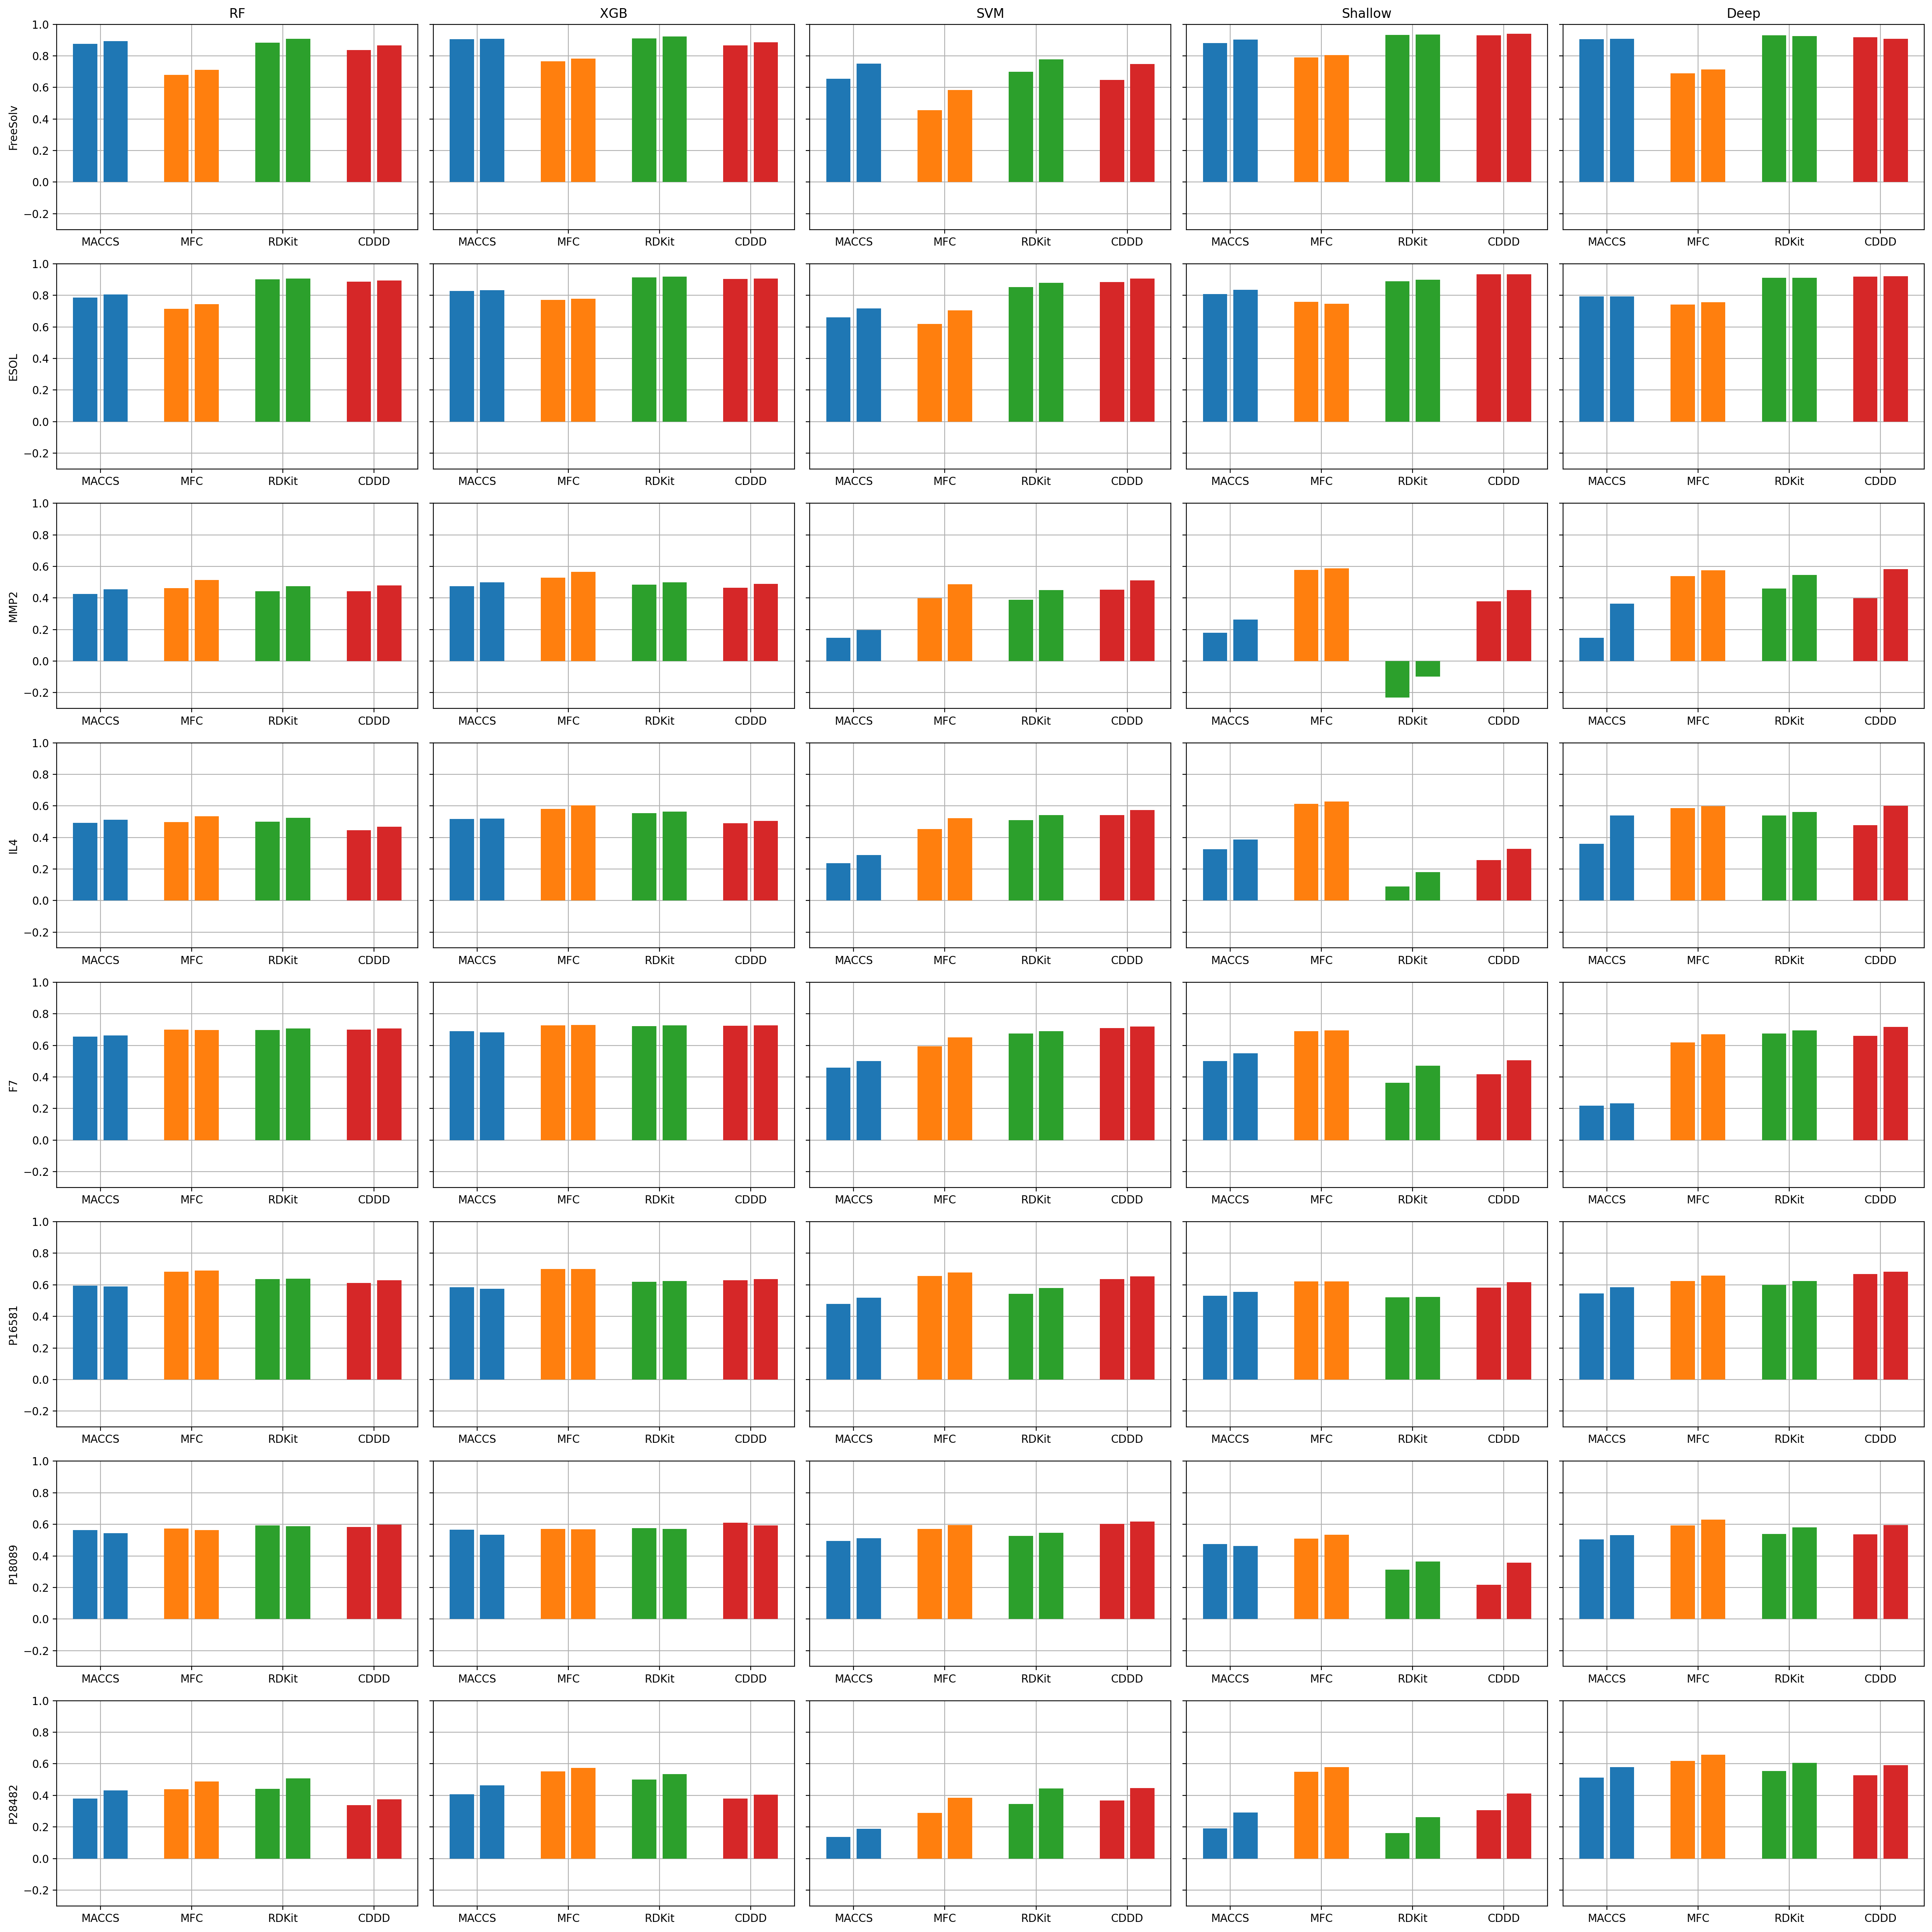

In [7]:
fig, axes = plt.subplots(8, 5, figsize=(25, 25), sharey=True)

diff_names = list()
pred_diffs = list()
kf_r2 = list()
bt_r2 = list()

for i, major_ax, name in zip(range(9), axes, dataset_names):
    for j, ax, algorithm in zip(range(5), major_ax, algorithm_names):
        correct_name = get_dataset_name_correct(name)
        # Select from kf
        kf_pred_name_subset = kf_pred_summary[kf_pred_summary['name'] == correct_name]
        kf_pred_name_algo_subset = kf_pred_name_subset[kf_pred_name_subset['algorithm'] == algorithm]
        # Select from bt
        bt_pred_name_subset = bt_pred_summary[bt_pred_summary['name'] == correct_name]
        bt_pred_name_algo_subset = bt_pred_name_subset[bt_pred_name_subset['algorithm'] == algorithm]
        
        x = [.5, 1.5,  3.5, 4.5,  6.5, 7.5,  9.5, 10.5]
        height = list()
        
        kf_heights = list()
        bt_heights = list()

        for descriptor_name in descriptor_names:
            # Get data for bar plots
            kf_pred_height = kf_pred_name_algo_subset[kf_pred_name_algo_subset['descriptor'] == descriptor_name]['member_100'].values[0]
            kf_heights.append(kf_pred_height)
            kf_r2.append(kf_pred_height)
            bt_pred_height = bt_pred_name_algo_subset[bt_pred_name_algo_subset['descriptor'] == descriptor_name]['member_100'].values[0]
            bt_heights.append(bt_pred_height)
            bt_r2.append(bt_pred_height)
            # Collect differences
            correct_descriptor_name = descriptor_name
            #if descriptor_name == 'ECFC':
            #    correct_descriptor_name = 'MFC'
            #diff_names.append(f'{correct_name} {algorithm}/{correct_descriptor_name}')
            diff_names.append(f'{correct_name} {algorithm}/{descriptor_name}')
            pred_diffs.append(np.abs(kf_pred_height) - np.abs(bt_pred_height))
        pre_height = list(zip(kf_heights, bt_heights))
        height = [item for sublist in pre_height for item in sublist]
        
        ax.grid(zorder=1000)
        ax.bar(x, height, 
               color=['C0', 'C0', 'C1', 'C1', 'C2', 'C2', 'C3', 'C3'],
               zorder=100)
        ax.set_ylim((-.3, 1))
        ax.set_xticks([1, 4, 7, 10])
        ax.set_xticklabels(['MACCS', 'MFC', 'RDKit', 'CDDD'])
        if i == 0:
            ax.set_title(algorithm)
        if j == 0:
            #ax.set_ylabel('$R^2$')
            ax.set_ylabel(get_dataset_name_correct(name))
plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.savefig(f'{PLOT_FOLDER}predictive_barplots.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Uncertainty performance

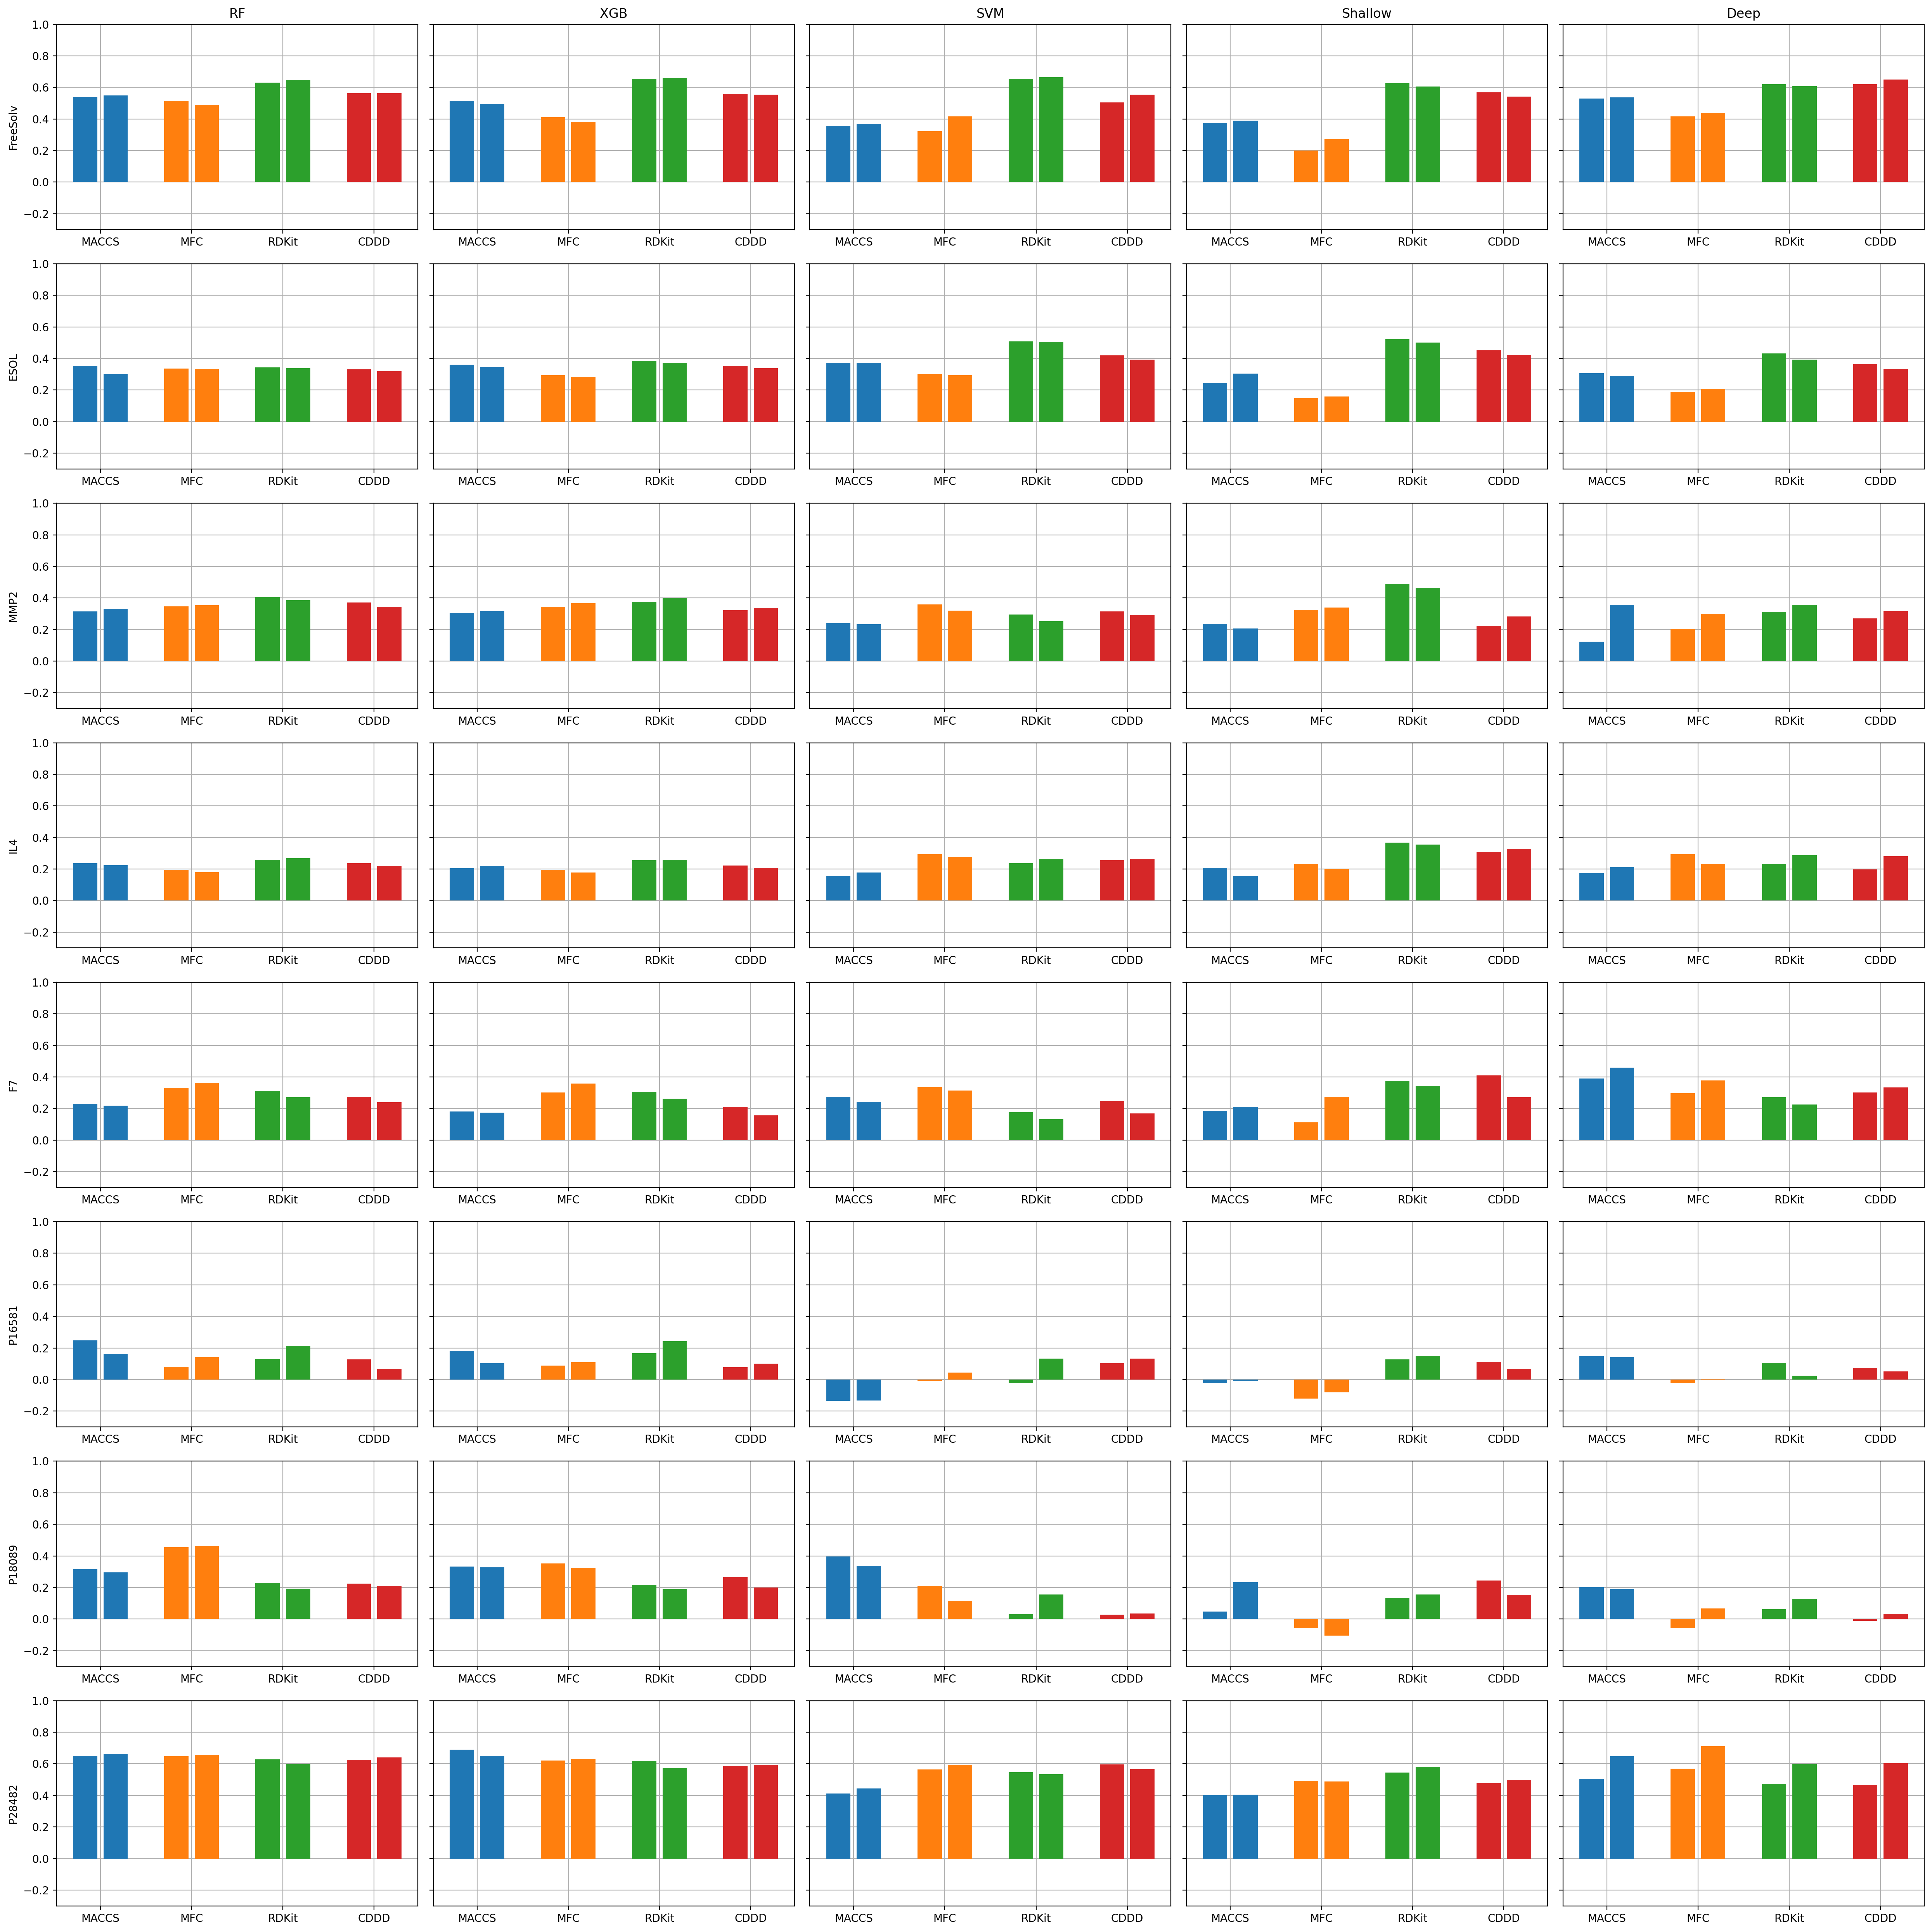

In [8]:
fig, axes = plt.subplots(8, 5, figsize=(25, 25), sharey=True)

unct_diffs = list()
kf_rho = list()
bt_rho = list()

for i, major_ax, name in zip(range(9), axes, dataset_names):
    for j, ax, algorithm in zip(range(5), major_ax, algorithm_names):
        correct_name = get_dataset_name_correct(name)
        # Select from kf
        kf_unct_name_subset = kf_unct_summary[kf_unct_summary['name'] == correct_name]
        kf_unct_name_algo_subset = kf_unct_name_subset[kf_unct_name_subset['algorithm'] == algorithm]
        # Select from bt
        bt_unct_name_subset = bt_unct_summary[bt_unct_summary['name'] == correct_name]
        bt_unct_name_algo_subset = bt_unct_name_subset[bt_unct_name_subset['algorithm'] == algorithm]
        
        x = [.5, 1.5,  3.5, 4.5,  6.5, 7.5,  9.5, 10.5]
        height = list()
        
        kf_heights = list()
        bt_heights = list()

        for descriptor_name in descriptor_names:
            # Get data for bar plots
            kf_unct_height = kf_unct_name_algo_subset[kf_unct_name_algo_subset['descriptor'] == descriptor_name]['member_100'].values[0]
            kf_heights.append(kf_unct_height)
            kf_rho.append(kf_unct_height)
            bt_unct_height = bt_unct_name_algo_subset[bt_unct_name_algo_subset['descriptor'] == descriptor_name]['member_100'].values[0]
            bt_heights.append(bt_unct_height)
            bt_rho.append(bt_unct_height)
            # Collect differences
            unct_diffs.append(np.abs(kf_unct_height) - np.abs(bt_unct_height))
        pre_height = list(zip(kf_heights, bt_heights))
        height = [item for sublist in pre_height for item in sublist]
        
        ax.grid(zorder=1000)
        ax.bar(x, height, 
               color=['C0', 'C0', 'C1', 'C1', 'C2', 'C2', 'C3', 'C3'],
               zorder=100)
        ax.set_ylim((-.3, 1))
        ax.set_xticks([1, 4, 7, 10])
        ax.set_xticklabels(descriptor_names)
        if i == 0:
            ax.set_title(algorithm)
        if j == 0:
            #ax.set_ylabel('$R^2$')
            ax.set_ylabel(get_dataset_name_correct(name))
plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.savefig(f'{PLOT_FOLDER}uncertainty_barplots.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Evaluate differences

In [9]:
# Unite
diff_df = pd.DataFrame(index=diff_names)
diff_df['kf_r2'] = kf_r2
diff_df['bt_r2'] = bt_r2
diff_df['pred'] = pred_diffs
diff_df['kf_rho'] = kf_rho
diff_df['bt_rho'] = bt_rho
diff_df['unct'] = unct_diffs

Get smallest and biggest differences, predictive

In [10]:
diff_df.reindex(diff_df['pred'].abs().sort_values().index)

,kf_r2,bt_r2,pred,kf_rho,bt_rho,unct
P16581 Shallow/MFC,0.622460,0.622777,-0.000316,-0.120909,-0.081089,0.039820
ESOL Deep/RDKit,0.911677,0.911303,0.000374,0.431962,0.391975,0.039987
F7 RF/MFC,0.698874,0.698414,0.000460,0.330500,0.362575,-0.032075
ESOL Shallow/CDDD,0.934726,0.934140,0.000586,0.451364,0.422413,0.028951
ESOL Deep/MACCS,0.792530,0.793400,-0.000870,0.307594,0.288488,0.019106
...,...,...,...,...,...,...
MMP2 Shallow/RDKit,-0.231477,-0.097440,0.134037,0.489852,0.464670,0.025182
P18089 Shallow/CDDD,0.215713,0.356832,-0.141119,0.243247,0.153719,0.089528
IL4 Deep/MACCS,0.359667,0.539994,-0.180327,0.172669,0.213293,-0.040624
MMP2 Deep/CDDD,0.399054,0.583938,-0.184883,0.270870,0.317765,-0.046896


In [11]:
diff_df.reindex(diff_df['pred'].abs().sort_values(ascending=False).index)

,kf_r2,bt_r2,pred,kf_rho,bt_rho,unct
MMP2 Deep/MACCS,0.148106,0.364339,-0.216233,0.122071,0.355745,-0.233674
MMP2 Deep/CDDD,0.399054,0.583938,-0.184883,0.270870,0.317765,-0.046896
IL4 Deep/MACCS,0.359667,0.539994,-0.180327,0.172669,0.213293,-0.040624
P18089 Shallow/CDDD,0.215713,0.356832,-0.141119,0.243247,0.153719,0.089528
MMP2 Shallow/RDKit,-0.231477,-0.097440,0.134037,0.489852,0.464670,0.025182
...,...,...,...,...,...,...
ESOL Deep/MACCS,0.792530,0.793400,-0.000870,0.307594,0.288488,0.019106
ESOL Shallow/CDDD,0.934726,0.934140,0.000586,0.451364,0.422413,0.028951
F7 RF/MFC,0.698874,0.698414,0.000460,0.330500,0.362575,-0.032075
ESOL Deep/RDKit,0.911677,0.911303,0.000374,0.431962,0.391975,0.039987


Get median of differences, predictive

In [12]:
diff_df['pred'].abs().median()

0.02420908724534443

Get smallest and biggest differences, uncertainty

In [13]:
diff_df.reindex(diff_df['unct'].abs().sort_values().index)

,kf_r2,bt_r2,pred,kf_rho,bt_rho,unct
FreeSolv RF/CDDD,0.837055,0.866108,-0.029053,0.563835,0.564409,-0.000574
ESOL SVM/MACCS,0.659834,0.717960,-0.058125,0.373706,0.372566,0.001139
ESOL SVM/RDKit,0.852308,0.879360,-0.027052,0.507484,0.505876,0.001608
P16581 SVM/MACCS,0.478698,0.517524,-0.038826,-0.134654,-0.132020,0.002633
ESOL RF/MFC,0.714537,0.744009,-0.029472,0.336265,0.333568,0.002697
...,...,...,...,...,...,...
P28482 Deep/MFC,0.617577,0.657857,-0.040280,0.569123,0.711273,-0.142150
P28482 Deep/MACCS,0.512340,0.578506,-0.066166,0.503999,0.647927,-0.143928
F7 Shallow/MFC,0.689030,0.694514,-0.005483,0.111714,0.275534,-0.163819
P18089 Shallow/MACCS,0.474462,0.463861,0.010601,0.046222,0.235005,-0.188782


In [14]:
diff_df.reindex(diff_df['unct'].abs().sort_values(ascending=False).index)

,kf_r2,bt_r2,pred,kf_rho,bt_rho,unct
MMP2 Deep/MACCS,0.148106,0.364339,-0.216233,0.122071,0.355745,-0.233674
P18089 Shallow/MACCS,0.474462,0.463861,0.010601,0.046222,0.235005,-0.188782
F7 Shallow/MFC,0.689030,0.694514,-0.005483,0.111714,0.275534,-0.163819
P28482 Deep/MACCS,0.512340,0.578506,-0.066166,0.503999,0.647927,-0.143928
P28482 Deep/MFC,0.617577,0.657857,-0.040280,0.569123,0.711273,-0.142150
...,...,...,...,...,...,...
ESOL RF/MFC,0.714537,0.744009,-0.029472,0.336265,0.333568,0.002697
P16581 SVM/MACCS,0.478698,0.517524,-0.038826,-0.134654,-0.132020,0.002633
ESOL SVM/RDKit,0.852308,0.879360,-0.027052,0.507484,0.505876,0.001608
ESOL SVM/MACCS,0.659834,0.717960,-0.058125,0.373706,0.372566,0.001139


In [15]:
diff_df.reindex(diff_df['unct'].abs().sort_values().index).iloc[150:, :]

,kf_r2,bt_r2,pred,kf_rho,bt_rho,unct
P16581 SVM/RDKit,0.542131,0.579639,-0.037508,-0.022007,0.132043,-0.110036
P28482 Deep/RDKit,0.553175,0.605729,-0.052554,0.473068,0.598248,-0.125180
P18089 SVM/RDKit,0.525991,0.546885,-0.020894,0.029239,0.156015,-0.126776
F7 Shallow/CDDD,0.418040,0.505799,-0.087759,0.410048,0.273107,0.136940
P28482 Deep/CDDD,0.526232,0.591065,-0.064833,0.465147,0.602715,-0.137568
P28482 Deep/MFC,0.617577,0.657857,-0.040280,0.569123,0.711273,-0.142150
P28482 Deep/MACCS,0.512340,0.578506,-0.066166,0.503999,0.647927,-0.143928
F7 Shallow/MFC,0.689030,0.694514,-0.005483,0.111714,0.275534,-0.163819
P18089 Shallow/MACCS,0.474462,0.463861,0.010601,0.046222,0.235005,-0.188782
MMP2 Deep/MACCS,0.148106,0.364339,-0.216233,0.122071,0.355745,-0.233674


Get median of differences, uncertainty

In [16]:
diff_df['unct'].abs().median()

0.02469475100938201

Count how many times KFold was the winner, predictive

In [17]:
print(f'Out of {len(diff_df)} times, {sum(diff_df["pred"] > 0)} times KFold induced the better predictive performance.')

Out of 160 times, 19 times KFold induced the better predictive performance.


Count how many times Bootstrap was the winner, predictive

In [18]:
print(f'Out of {len(diff_df)} times, {sum(diff_df["unct"] > 0)} times KFold induced the better uncertainty performance.')

Out of 160 times, 83 times KFold induced the better uncertainty performance.
